In [1]:
import numpy as np
from ase.io import read
from ase.visualize import view
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

import xml.etree.ElementTree as ET
from scipy.interpolate import CubicSpline
from tqdm import tqdm

import math

In [2]:
N = 100
frames = read('exfoliation_mbd_reference.xyz', index=':{}'.format(N))

In [3]:
def R6_fit(r_array, c):
    try:
        r_array.shape[1]
        return -c*np.sum(np.power(r_array,-6.),axis=1)
    except:
        return -c*np.sum(np.power(r_array,-6.))


def get_rArray(frame, indices_layer1, indices_layer2, cutoff):
    # This function returns an array which contains all the distances from the atoms
    # in the lower layer to the atoms in the upper layer, up to the cutoff distance

    # multiplicate the cell up to the cutoff distance
    vec_cell = frame.cell.cellpar()
    M1, M2, M3 = vec_cell[0]**2, vec_cell[1]**2, vec_cell[2]**2
    M12 = vec_cell[0]*vec_cell[1]*np.cos(vec_cell[5]*np.pi/180)
    M13 = vec_cell[0]*vec_cell[2]*np.cos(vec_cell[4]*np.pi/180)
    M23 = vec_cell[1]*vec_cell[2]*np.cos(vec_cell[3]*np.pi/180)
    det_M = M1*M2*M3-M1*M23**2-M2*M13**2-M3*M12**2+2*M12*M13*M23
    N1=math.ceil(np.sqrt((M2*M3-M23**2)/det_M)*cutoff)
    N2=1
    N3=math.ceil(np.sqrt((M1*M2-M12**2)/det_M)*cutoff)
    
    pbc = frame.get_pbc()
    cell_size = [(2*N1+1) if pbc[0] else 1,
                  (2*N2+1) if pbc[1] else 1, 
                  (2*N3+1) if pbc[2] else 1]
    n_headcells = math.floor(np.prod(cell_size)/2)
    incre = n_headcells * len(frame)
    indices_layer1 = np.array(indices_layer1) + incre
    indices_layer2 = np.array(indices_layer2) + incre
    frame2=frame*(cell_size[0],cell_size[1],cell_size[2])
    dist_idx = np.arange((len(frame2)))
    
    # sort out the indices of atoms from different layers
    layer1_y = np.unique(frame2.get_positions()[indices_layer1,1])
    layer2_y = np.unique(frame2.get_positions()[indices_layer2,1])
    
    rList = []
    dist_matrix = frame2.get_all_distances()
    for i in indices_layer1:
        i_distances = dist_matrix[i]
        for j in dist_idx:
            if frame2[j].position[1] in layer1_y:
                pass
            else:
                rList.append(i_distances[j])

    for i in indices_layer2:
        i_distances = dist_matrix[i]
        for j in dist_idx:
            if frame2[j].position[1] in layer2_y:
                pass
            else:
                rList.append(i_distances[j])

    return np.array(rList)

100%|██████████| 100/100 [01:48<00:00,  1.09s/it]


[37.40406611]
[[0.1132697]]


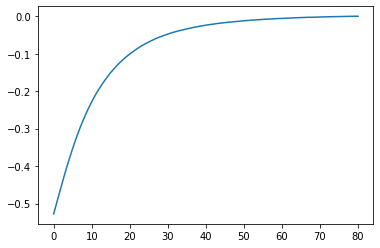

In [4]:
r_array_array = []
e_list = []
ref_energy = frames[-1].get_total_energy()

for frame in tqdm(frames):
    r_array = get_rArray(frame,[0,1,2,3],[4,5,6,7],20)
    if min(r_array) < 4:
        pass
    else:
        r_array_array.append(r_array)
        e_list.append(frame.get_total_energy()-ref_energy)
r_array_array=np.array(r_array_array)

popt, pcov = curve_fit(R6_fit, r_array_array, e_list)

x=np.arange(len(e_list))
plt.plot(x,e_list)
print(popt)
print(pcov)

In [5]:
c = popt[0]
def R6(r,c):
    return -2*c*np.power(r,-6.)

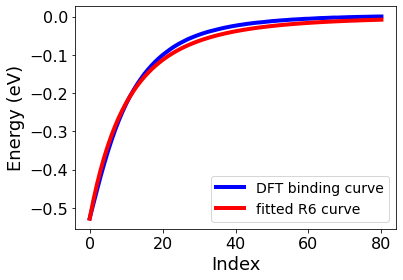

In [6]:
e_list=np.array(e_list)
b=R6_fit(r_array_array,c)

fig, ax = plt.subplots(figsize=(5.7,4))
ax.plot(x,e_list,color='blue',label='DFT binding curve',linewidth = 4)
ax.plot(x,b,color='red',label='fitted R6 curve',linewidth = 4)
ax.tick_params(labelsize=16)
ax.set_xlabel('Index',fontsize=18)
ax.set_ylabel('Energy (eV)',fontsize=18)
ax.legend(markerscale=2,fontsize=14)
plt.tight_layout()

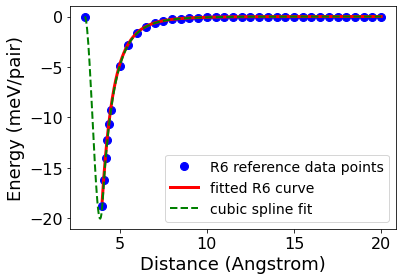

In [7]:
tree = ET.parse('P_r6_innercut.xml')
root = tree.getroot()

r=[]
energy=[]
for i in root.iter('potential_pair'):
    for j in i.iter():
        if j.tag != 'potential_pair':
            r.append(float(j.attrib['r']))
            energy.append(float(j.attrib['E']))
        else:
            pass

energy=np.array(energy)
r=np.array(r)

r_new = np.linspace(3.,20,500)
r_R6=np.linspace(4,20,500)
R6_baseline=[]
for rr in r_R6:
    R6_baseline.append(R6(rr,c))

### base_func is the ultimate baseline function! Its domain is [3,20].
### Its unit is eV/atom!

fig, ax = plt.subplots(figsize=(5.7,4))
base_func = CubicSpline(r, energy, bc_type = 'clamped',extrapolate = False)
ax.plot(r, 1000*energy, 'o',ms=8,c='blue',label='R6 reference data points')
ax.plot(r_R6, 1000*np.array(R6_baseline),color='r',linewidth=3, label='fitted R6 curve')
ax.plot(r_new, 1000*base_func(r_new), '--',color='green',linewidth=2,label='cubic spline fit')
ax.tick_params(labelsize=16)
ax.set_xlabel('Distance (Angstrom)',fontsize=18)
ax.set_ylabel('Energy (meV/pair)',fontsize=18)
ax.legend(markerscale=1,fontsize=14)
plt.tight_layout()

In [8]:
print(r)

[ 3.   4.   4.1  4.2  4.3  4.4  4.5  5.   5.5  6.   6.5  7.   7.5  8.
  8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5 14.  14.5 15.
 15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20. ]
